In [66]:
import torch
import torch.nn as nn
from dataloader import DataLoader

In [67]:
IMG_DIM = 28
MNIST_PATH = r"/home/anton/KTH/year5/5LSH0/mnist"
EPOCHS = 50
BATCH_SIZE = 500
LEARNING_RATE = 1e-3
MOMENTUM = 1e-4
WEIGHT_DECAY = 1e-5
CORRUPT_DATA = None

In [68]:
class Autoencoder(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [69]:
from torch.utils.tensorboard import SummaryWriter
from torch import optim
import time

model = Autoencoder()
criterion = nn.MSELoss() 
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    # momentum=MOMENTUM
)
print(model.train())

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


In [70]:

writer = SummaryWriter("runs/cnn_ae")

def train(train_loader, val_loader, epochs):
    

    tic = time.perf_counter()

    for epoch in range(1, epochs+1):
        train_loss = 0
        num_samples = 0
        for _, (image, _) in enumerate(train_loader):
            # image = image.reshape(-1, IMG_DIM * IMG_DIM)            
            reconstructed_image = model(image)
            loss = criterion(reconstructed_image, image)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()
            num_samples += image.size(0) 

        toc = time.perf_counter()
        time_format = time.strftime("%M:%S", time.gmtime(toc - tic))
        
        train_loss = train_loss / num_samples
        _, _, val_loss = evaluate_batch(val_loader)
        
        print(f"Time elapsed: {time_format}, epoch: {str(epoch).zfill(2)}/{epochs}, train_loss: {train_loss*100:.5f}, val_loss: {val_loss*100:.5f}")
        writer.add_scalar("train_mse_loss", train_loss, epoch)
        writer.add_scalar("val_mse_loss", val_loss, epoch)
        writer.add_images("original_image", image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")
        writer.add_images("reconstructed_image", reconstructed_image.reshape(-1, IMG_DIM, IMG_DIM)[0], epoch, dataformats="HW")

def evaluate_batch(data_loader):
    with torch.no_grad():
        tot_loss = 0
        num_samples = 0
        for _, (images, label) in enumerate(data_loader): 
            reconstructed_image = model(images)
            tot_loss += criterion(reconstructed_image, images).item()
            num_samples += images.size(0)
        loss = tot_loss / num_samples
    return images, reconstructed_image, loss

def evaluate_image(data_loader):
    with torch.no_grad():
        out = []
        for _, (images, labels) in enumerate(data_loader):
            for image, label in zip(images, labels):
                print(image.shape)
                reconstructed_image = model(image)
                loss = criterion(reconstructed_image, image).item()
                out.append((image.numpy(), reconstructed_image.numpy(), loss, label.item()))
    return out

def predict(data_loader, threshold):
    out = evaluate_image(data_loader)
    labels = [element[3] for element in out]
    preds = [int(element[2] < threshold) for element in out]
    return preds, labels

In [71]:
dl = DataLoader()
dl.prepareMNIST(mnist_path=MNIST_PATH, num_train_data=5000, num_normal_data=100, num_anomaly_data=100, corrupt_train=CORRUPT_DATA)
train_loader, val_loader, normal_loader, anomaly_loader = dl.getDataLoaderMNIST(batch_size=BATCH_SIZE)


In [72]:
train(train_loader, val_loader, epochs=EPOCHS)
writer.flush()

Time elapsed: 00:08, epoch: 01/50, train_loss: 0.02589, val_loss: 0.05972
Time elapsed: 00:18, epoch: 02/50, train_loss: 0.01541, val_loss: 0.04554
Time elapsed: 00:29, epoch: 03/50, train_loss: 0.00996, val_loss: 0.03444
Time elapsed: 00:40, epoch: 04/50, train_loss: 0.00592, val_loss: 0.02814
Time elapsed: 00:50, epoch: 05/50, train_loss: 0.00360, val_loss: 0.02596
Time elapsed: 01:00, epoch: 06/50, train_loss: 0.00247, val_loss: 0.02452
Time elapsed: 01:09, epoch: 07/50, train_loss: 0.00188, val_loss: 0.02345
Time elapsed: 01:18, epoch: 08/50, train_loss: 0.00153, val_loss: 0.02278
Time elapsed: 01:29, epoch: 09/50, train_loss: 0.00129, val_loss: 0.02230
Time elapsed: 01:38, epoch: 10/50, train_loss: 0.00112, val_loss: 0.02190
Time elapsed: 01:46, epoch: 11/50, train_loss: 0.00100, val_loss: 0.02151
Time elapsed: 01:55, epoch: 12/50, train_loss: 0.00090, val_loss: 0.02121
Time elapsed: 02:04, epoch: 13/50, train_loss: 0.00083, val_loss: 0.02091
Time elapsed: 02:15, epoch: 14/50, tra

In [73]:
MODEL_PATH = r"model/cnn_ae.pt"
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 2

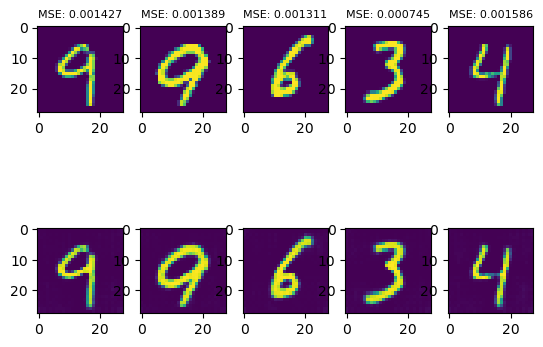

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 2

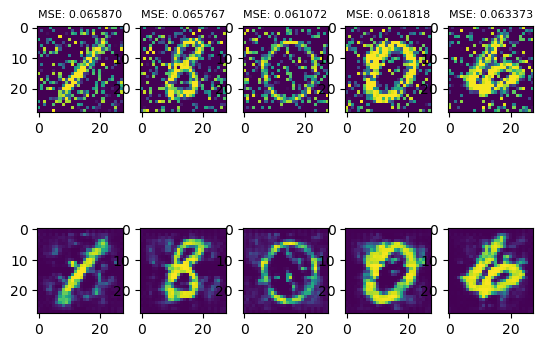

In [75]:
import matplotlib.pyplot as plt
import numpy as np

FIGURE_FONT_SIZE = 8
fig = plt.figure()
out = evaluate_image(normal_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in out])
std_loss = np.std([element[2] for element in out])
print(f"mean loss for normal data: {mean_loss}, std: {std_loss}")

plt.savefig(f"regular_training_normal_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()

fig = plt.figure()
out = evaluate_image(anomaly_loader)
for i in range(1, 6):
        original_image, reconstrucet_image, loss, _ = out[i]
        ax1 = fig.add_subplot(2, 5, i)
        ax1.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(original_image).reshape(IMG_DIM, IMG_DIM))
        ax2 = fig.add_subplot(2, 5, i+5)
        # ax2.set_title(f"MSE: {loss:2f}", fontsize=FIGURE_FONT_SIZE) 
        plt.imshow(np.array(reconstrucet_image).reshape(IMG_DIM, IMG_DIM))

mean_loss = np.mean([element[2] for element in out])
std_loss = np.std([element[2] for element in out])

print(f"mean loss for anomaly data: {mean_loss}, std: {std_loss}")

plt.savefig(f"regular_training_anomaly_reconstruction_MNIST_noise_lvl{'03'}")
plt.show()
plt.close()